# MIOFlow data preparation

Prerequisites:
- You have preprocessed your adata using some time smoothing method into the data/preprocessed directory. [notebook: 3-time-pseudotime-meld]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - phate visualization space of the data on _obsm_ (ex.: adata.obsm['X_phate_visualization])
    - any extra metadata on _obs_ (ex.: adata.obs['time_label'], adata.obs['disease_progression'], etc...)
    - smoothed time in the on _obsm_ (ex.: adata.obsm['smooth_time'])

- You have trained and saved a Dimension Changer Encoder/Decoder [notebook: 4-dimension-changer]:
    - saved under the `DIMENSION_CHANGER_DIR = '../../dimension_changer'`


In this notebook, we will:
- Prepare the data to run MIOFLOW on top of it

# TODO: BETTER DESCRIPTION OF THIS NOTEBOOK

In [34]:
import scanpy as sc
import os
import pandas as pd
import scprep

PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')
DIMENSION_CHANGER_DIR = os.path.join('../../dimension_changer')
RESULTS_DIR = os.path.join('../../results')
os.makedirs(RESULTS_DIR, exist_ok=True)


data_name = 'adata'

SAVE_PATH = os.path.join(RESULTS_DIR, data_name)
os.makedirs(SAVE_PATH, exist_ok=True)

adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata_time.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'

# We will now bin our time, to have a guidance to our MIOFlow to infer trajectories

In [35]:
adata.obs['bin_time'] = pd.cut(adata.obs['smooth_time'], bins=10, labels=False)
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time', 'bin_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'

#### Before we analyse the binned time, let's remeber how our initial PHATE looked.

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

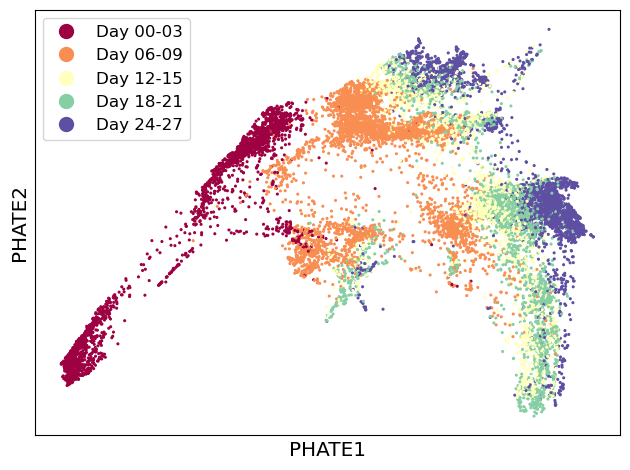

In [36]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['time_label'], cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

#### We then binned it to retrieve a meld scored over a smoothed time

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

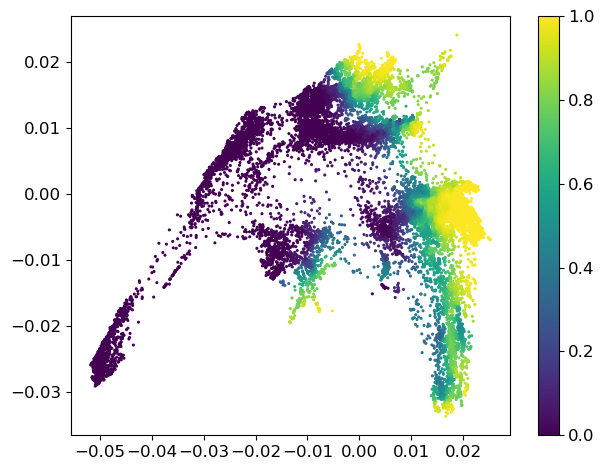

In [37]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['smooth_time'], cmap='viridis')

#### Here the binned time is just a way to discretized the continuous smooth time score

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


bin_time
0    6598
9    3412
8    1527
7    1442
6    1176
5    1113
4     910
3     670
1     642
2     454
Name: count, dtype: int64


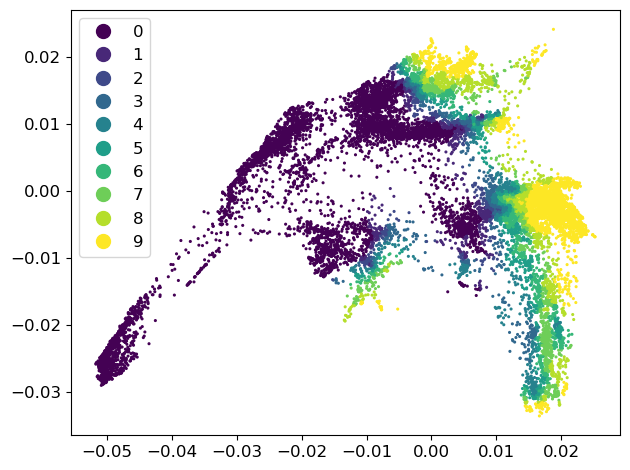

In [38]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['bin_time'], cmap='viridis')
print(adata.obs['bin_time'].value_counts())

## Finally, we create the MIOFlow DataFrame, that is saving for each datapoint what is it's label ina  discretized manner.

In [39]:
mioflow_df = pd.DataFrame(adata.obsm['X_phate'], columns=[f'd{i}' for i in range(1, adata.obsm['X_phate'].shape[1]+1)])
mioflow_df['samples'] = adata.obs['bin_time'].values
mioflow_df

,d1,d2,samples
0,-0.039307,-0.009408,0
1,-0.032129,-0.000242,0
2,-0.022984,0.007698,0
3,-0.021853,0.008034,0
4,-0.047105,-0.019664,0
...,...,...,...
17939,0.014351,-0.001720,8
17940,0.015902,-0.004180,9
17941,0.022290,-0.005536,9
17942,0.023625,-0.006161,9


### And we save the mioflow_df to the results as well as save a new version of our adata object

In [40]:
mioflow_df.to_csv(os.path.join(SAVE_PATH,'mioflow_data_10d.csv'), index=False)

adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_mioflow.h5ad'))
adata

AnnData object with n_obs × n_vars = 17944 × 18019
    obs: 'time_label', 'smooth_time', 'bin_time'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
    varm: 'PCs'